In [ ]:
!wget https://vision.middlebury.edu/mview/data/data/dinoRing.zip --no-check-certificate

--2020-11-25 13:49:48--  https://vision.middlebury.edu/mview/data/data/dinoRing.zip
Resolving vision.middlebury.edu (vision.middlebury.edu)... 140.233.20.14
Connecting to vision.middlebury.edu (vision.middlebury.edu)|140.233.20.14|:443... connected.
  Unable to locally verify the issuer's authority.
HTTP request sent, awaiting response... 200 OK
Length: 11435464 (11M) [application/zip]
Saving to: ‘dinoRing.zip’

dinoRing.zip        100%[===================>]  10.91M  12.1MB/s    in 0.9s    

2020-11-25 13:49:49 (12.1 MB/s) - ‘dinoRing.zip’ saved [11435464/11435464]



In [ ]:
!pip install --upgrade PyMCubes
!pip install pycollada

     |████████████████████████████████| 266kB 12.1MB/s 
     |████████████████████████████████| 112kB 11.5MB/s 
  Created wheel for pycollada: filename=pycollada-0.7.1-cp36-none-any.whl size=125610 sha256=73856a6dcfd43de0a8062d7c641cbca0b5c17f7a26825b6305f61f285f1c9638
  Stored in directory: /root/.cache/pip/wheels/b0/5d/2a/e6af10b1976334ef7bdea943abff28254b6431bca2b0f18bbc
Successfully built pycollada


In [ ]:
import cv2
import numpy as np
from itertools import product
import numpy as np
import mcubes

In [ ]:
data_dir = "suzanne/"
file_base = "suzanne"
T = 19

In [ ]:
!unzip suzanne.zip

Archive:  suzanne.zip
   creating: suzanne/
  inflating: __MACOSX/._suzanne      
  inflating: suzanne/suzanne_54.png  
  inflating: suzanne/suzanne_40.png  
  inflating: suzanne/suzanne_68.png  
  inflating: suzanne/suzanne_97.png  
  inflating: suzanne/suzanne_83.png  
  inflating: suzanne/suzanne_119.png  
  inflating: suzanne/suzanne_118.png  
  inflating: suzanne/suzanne_82.png  
  inflating: suzanne/suzanne_96.png  
  inflating: suzanne/suzanne_69.png  
  inflating: suzanne/suzanne_41.png  
  inflating: suzanne/suzanne_55.png  
  inflating: suzanne/suzanne_43.png  
  inflating: suzanne/suzanne_57.png  
  inflating: suzanne/suzanne_80.png  
  inflating: suzanne/suzanne_94.png  
  inflating: suzanne/suzanne_95.png  
  inflating: suzanne/suzanne_81.png  
  inflating: suzanne/suzanne_56.png  
  inflating: suzanne/suzanne_42.png  
  inflating: suzanne/suzanne_46.png  
  inflating: suzanne/suzanne_52.png  
  inflating: suzanne/suzanne_85.png  
  inflating: suzanne/suzanne_91.png  
  in

# Reading Images and Camera Parameters

In [ ]:
# Reading the camera parameters from 'dinoSR_par.txt'
with open(data_dir + "/" + "par.txt", 'r') as f:
  lines = f.readlines() 

  M_ALL = []
  for l in lines[1:]: 
    tmp = np.array(l.strip().split(" ")).astype(np.float32)
    M_ALL.append(tmp.reshape((3, 4)))

  N = len(lines) - 1

In [ ]:
EXPERIMENT_INDICES = []

for i in range(N):
  EXPERIMENT_INDICES.append(np.linspace(0, N - 1, (i + 1)).astype(int).tolist())

In [ ]:
print(M_ALL[0])

[[-8.783267e+02  0.000000e+00 -3.479448e+02  1.599999e+02]
 [-1.587451e+02 -1.000000e+03  1.800000e+02  1.200000e+02]
 [-6.614000e-01  0.000000e+00  7.500000e-01  5.000000e-01]]


In [ ]:
# Reading images
imgs = []
kernel = np.ones((3,3), np.uint8) 
for i in range(N):
  im = cv2.imread(data_dir + "/" + file_base + "_" + str(i) + ".png", 0) / 255
  im = cv2.erode(im, kernel, iterations=1) 
  im = cv2.dilate(im, kernel, iterations=1) 
  _, im = cv2.threshold(im, 0.1, 1, cv2.THRESH_BINARY)
  imgs.append(np.array(im))
imgs = np.array(imgs)

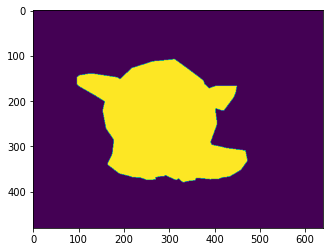

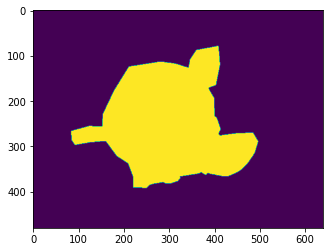

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(imgs[0])
plt.figure()
plt.imshow(imgs[1])

In [ ]:
# Thresholding images for masking
silhouettes_ALL = []
for im in imgs:
  silhouettes_ALL.append(im > 0)
silhouettes_ALL = np.array(silhouettes_ALL).transpose(1, 2, 0)

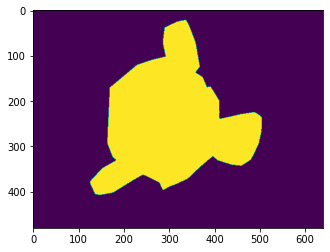

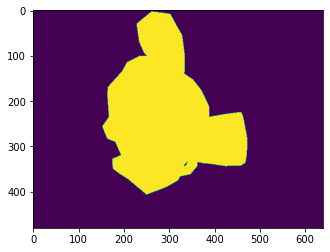

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(silhouettes_ALL[:, :, 2])
plt.figure()
plt.imshow(silhouettes_ALL[:, :, 46])

# Visual Hull

In [ ]:
# Define a voxel grid which has the 3D locations of each voxel which can then be projected onto each image
def InitializeVoxels(xlim, ylim, zlim, voxel_size):
  voxels_number = [1, 1, 1]
  voxels_number[0] = np.abs(xlim[1]-xlim[0]) / voxel_size[0]
  voxels_number[1] = np.abs(ylim[1]-ylim[0]) / voxel_size[1]
  voxels_number[2] = np.abs(zlim[1]-zlim[0]) / voxel_size[2]
  voxels_number_act = np.array(voxels_number).astype(int) + 1
  total_number = np.prod(voxels_number_act)

  voxel = np.ones((np.int(total_number), 4))

  sx = xlim[0]
  ex = xlim[1]
  sy = ylim[0]
  ey = ylim[1]
  sz = zlim[0]
  ez = zlim[1]

  if(ex > sx):
    x_step = voxel_size[0];
  else:
    x_step = -voxel_size[0];

  if(ey > sy):
    y_step = voxel_size[1];
  else:
    y_step = -voxel_size[1];

  if(ez > sz):
    z_step = voxel_size[2];
  else:
    z_step = -voxel_size[2];

  voxel3Dx, voxel3Dy, voxel3Dz = np.meshgrid(np.linspace(sx, ex, voxels_number_act[0]), 
                                             np.linspace(sy, ey, voxels_number_act[1]),
                                             np.linspace(sz, ez, voxels_number_act[2]))
  
  l = 0;
  for z in np.linspace(sz, ez, voxels_number_act[2]):
    for x in np.linspace(sx, ex, voxels_number_act[0]):
      for y in np.linspace(sy, ey, voxels_number_act[1]):
        voxel[l] = [x, y, z, 1] 
        l=l+1

  return voxel, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number

In [ ]:
def ConvertVoxelList2Voxel3D(voxels_number, voxel_size, voxel):
  sx = -(voxels_number[0] / 2) * voxel_size[0]
  ex = voxels_number[0] / 2 * voxel_size[0]

  sy = -(voxels_number[1] / 2) * voxel_size[1]
  ey = voxels_number[1] / 2 * voxel_size[1]

  sz = -(voxels_number[2] / 2) * voxel_size[2] # 0;
  ez = voxels_number[2] / 2 * voxel_size[2] # voxels_number[2] * voxel_size[2]
  voxels_number = np.array(voxels_number).astype(np.int32)
  voxel3D = np.zeros((voxels_number[1] + 1, voxels_number[0] + 1, voxels_number[2] + 1));

  l = 0
  z1 = 0
  for z in np.arange(sz, ez, voxel_size[2]):
      x1 = 0
      for x in np.arange(sx, ex, voxel_size[0]):
          y1 = 0
          for y in np.arange(sy, ey, voxel_size[1]):
              voxel3D[y1, x1, z1] = voxel[l, 3]
              l = l + 1
              y1 = y1 + 1
          x1 = x1 + 1
      z1 = z1 + 1

  return voxel3D

In [ ]:
for ind in range(120):
  num = EXPERIMENT_INDICES[ind]
  print(num)
  silhouettes = silhouettes_ALL[:, :, num]

  print(len(silhouettes))

  M = []
  for j in num:
    M.append(M_ALL[j])

  voxel_size = [0.005, 0.005, 0.005] # size of each voxel

  # The dimension limits
  # -1.3671875 -0.8515625 -0.984375
  xlim = [-1.4 * 0.09, 1.4 * 0.09] # [0.07, -0.04] # [-0.04, 0.07]
  ylim = [-1.4 * 0.09, 1.4 * 0.09] # [0.022, 0.132] # [0.04, 0.15]
  zlim = [-1.4 * 0.09, 1.4 * 0.09] # [0.07, -0.04] # [-0.04, 0.07]

  voxels, voxel3Dx, voxel3Dy, voxel3Dz, voxels_number = InitializeVoxels(xlim, ylim, zlim, voxel_size);

  print(voxels)

  object_points3D = np.copy(voxels).T

  voxels[:, 3] = 0 # making the fourth variable of each voxel 0

  proj = []

  for i in range(ind + 1):

    # CAMERA PARAMETERS
    M_ = M[i]

    # PROJECTION TO THE IMAGE PLANE
    points2D = np.matmul(M_, object_points3D)
    points2D = np.floor(points2D / points2D[2, :]).astype(np.int32)
    points2D[np.where(points2D < 0)] = 0; # check for negative image coordinates

    img_size = (silhouettes).shape
    ind1 = np.where(points2D[1, :] >= img_size[0]) # check for out-of-bounds (width) coordinate
    points2D[:, ind1] = 0
    ind1 = np.where(points2D[0, :] >= img_size[1]) # check for out-of-bounds (height) coordinate
    points2D[:, ind1] = 0

    # ACCUMULATE THE VALUE OF EACH VOXEL IN THE CURRENT IMAGE
    voxels[:, 3] += silhouettes[:, :, i].T[points2D.T[:, 0], points2D.T[:, 1]]

    proj.append(points2D)

  print(voxels)

  error_amount = 5
  maxv = np.max(voxels[:, 3])
  iso_value = maxv-np.round(((maxv)/100)*error_amount)-0.5
  print('max number of votes:' + str(maxv))
  print('threshold for marching cube:' + str(iso_value))

  voxel3D = ConvertVoxelList2Voxel3D(np.array(voxels_number), voxel_size, voxels)

  # debug
  # voxel3D[0, :, :] = maxv
  # voxel3D[-1, :, :] = maxv

  # voxel3D[:, 0, :] = maxv
  # voxel3D[:, -1, :] = maxv

  # voxel3D[:, :, 0] = maxv
  # voxel3D[:, :, -1] = maxv

  # Extract the 0-isosurface
  vertices, triangles = mcubes.marching_cubes(voxel3D, iso_value)

  # Export the result to sphere.dae
  mcubes.export_mesh(vertices, triangles, "suzanne_" + str(i) + ".dae", "suzanne_" + str(i))

[0]
480
[[-0.126   -0.126   -0.126    1.     ]
 [-0.126   -0.12096 -0.126    1.     ]
 [-0.126   -0.11592 -0.126    1.     ]
 ...
 [ 0.126    0.11592  0.126    1.     ]
 [ 0.126    0.12096  0.126    1.     ]
 [ 0.126    0.126    0.126    1.     ]]
[[-0.126   -0.126   -0.126    0.     ]
 [-0.126   -0.12096 -0.126    0.     ]
 [-0.126   -0.11592 -0.126    0.     ]
 ...
 [ 0.126    0.11592  0.126    0.     ]
 [ 0.126    0.12096  0.126    0.     ]
 [ 0.126    0.126    0.126    0.     ]]
max number of votes:1.0
threshold for marching cube:0.5
[0, 119]
480
[[-0.126   -0.126   -0.126    1.     ]
 [-0.126   -0.12096 -0.126    1.     ]
 [-0.126   -0.11592 -0.126    1.     ]
 ...
 [ 0.126    0.11592  0.126    1.     ]
 [ 0.126    0.12096  0.126    1.     ]
 [ 0.126    0.126    0.126    1.     ]]
[[-0.126   -0.126   -0.126    0.     ]
 [-0.126   -0.12096 -0.126    0.     ]
 [-0.126   -0.11592 -0.126    0.     ]
 ...
 [ 0.126    0.11592  0.126    0.     ]
 [ 0.126    0.12096  0.126    0.     ]
 [ 

In [ ]:
!find . -name 'suzanne_*' | zip Suzanne_EXPERIMENTS.zip -@

# Marching Cubes